# ConvLSTM

## Pre-setup

#### Import the required libraries

In [1]:
# Import the required libraries.
import os
import math
import random
import numpy as np
import datetime as datetime
from collections import deque
import matplotlib.pyplot as plt
#from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf

2022-11-03 13:02:22.505502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 13:02:22.627752: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 13:02:22.657894: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 13:02:23.270749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
from batch_data_generator import DataGenerator

Import tensorflow and check for GPU support

In [3]:
# Print num of GPUs if available to use
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

Set a seed to reproduce the results

In [4]:
seed_constant = 123
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Set data directories and other constants for the model

In [5]:
# Data paths are defined here
DATA_DIR = 'data'
VIDEO_PATH = os.path.join(DATA_DIR, 'videos')
ANNOTATION_PATH = os.path.join(DATA_DIR, 'annotations')
TRAINING_PATH = os.path.join(VIDEO_PATH, 'training')
TESTING_PATH = os.path.join(VIDEO_PATH, 'testing')
VALIDATION_PATH = os.path.join(VIDEO_PATH, 'validation')

In [6]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Set a minimum duration in seconds to extract sequence in multiples of
MIN_DURATION = 150

(DIMENSION_X, DIMENSION_Y, DIMENSION_C) = (224, 224, 3)

# Get the names of all classes/categories in our dataset.
CLASSES_LIST = os.listdir(TRAINING_PATH)

Define a easily readable class name mapping

In [7]:
class_mapping = {
'_cut___chop___slice_a_vegetable,_fruit,_or_meat_' : 'cut vegetables, herbs or meat',
'browse_through_clothing_items_on_rack___shelf___hanger' : 'browse through clothing items',
'clean___wipe_other_surface_or_object' : 'clean surface',
'dig_or_till_the_soil_with_a_hoe_or_other_tool' : 'till soil with a hoe',
'read_a_book___magazine___shopping_list_etc' : 'read a book',
'throw_away_trash___put_trash_in_trash_can' : 'throw away trash',
'wash_dishes___utensils___bakeware_etc' : 'wash utensils'}

## Read npy files in data generator

Get the file paths and corresponsing labels for the data generator (**Run everytime kernel is (re)started**)

In [8]:
def get_nparray_and_labels_in_partition(partition_path):
	nparrayfile_paths = []
	labels = {}
	for class_name in os.listdir(partition_path):
		if class_name not in CLASSES_LIST:
			print(f'{class_name} not found in class list!')
			continue
		for video_file_name in os.listdir(os.path.join(partition_path, class_name)):
			if not video_file_name.endswith('.npy'): continue
			nparrayfile_path = os.path.join(partition_path, class_name, video_file_name)
			nparrayfile_paths.append(nparrayfile_path)
			labels[nparrayfile_path] = CLASSES_LIST.index(class_name)
	return nparrayfile_paths, labels

Split the data into train, validation and test sets

In [9]:
nparray_partition = {}
nparray_labels = {}
nparray_partition['train'], nparray_labels['train'] = get_nparray_and_labels_in_partition(TRAINING_PATH)
nparray_partition['test'], nparray_labels['test'] = get_nparray_and_labels_in_partition(TESTING_PATH)
nparray_partition['validation'], nparray_labels['validation'] = get_nparray_and_labels_in_partition(VALIDATION_PATH)

Define parameters for data generator

In [10]:
train_data_generator_params = {
	'batch_size' : 5,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

validation_data_generator_params = {
	'batch_size' : 5,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

In [11]:
training_generator = DataGenerator(nparray_partition['train'], nparray_labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(nparray_partition['validation'], nparray_labels['validation'], **validation_data_generator_params)

## Create model - ConvLSTM

Imports

In [12]:
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Function to create keras sequential model

In [18]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    model.add(Input(shape=(SEQUENCE_LENGTH, DIMENSION_X, DIMENSION_Y, DIMENSION_C)))
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.4, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.4)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.4, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.4)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.4, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.4)))
    
    # model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
    #                      recurrent_dropout=0.2, return_sequences=True))
    # model.add(BatchNormalization())
    # model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Create model

In [19]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 30, 222, 222, 4)   1024      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 222, 222, 4)  16        
 hNormalization)                                                 
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 30, 111, 111, 4)  0         
 3D)                                                             
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 111, 111, 4)  0         
 tributed)                                                       
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 30, 109, 109, 8)   3488      
                                                      

Compile and train the model

In [20]:
%%time
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
optimizer = 'adam'
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])

CPU times: user 17.8 ms, sys: 6.79 ms, total: 24.6 ms
Wall time: 21.6 ms


In [21]:
%%time
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = training_generator, 
    validation_data = validation_generator,
    use_multiprocessing=True,
    workers=6, 
    epochs = 60,
    callbacks = [early_stopping_callback])

Epoch 1/60


2022-11-03 13:03:57.244794: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


197/197 [==============================] - 225s 1s/step - loss: 65.2234 - accuracy: 0.3939 - val_loss: 39.1838 - val_accuracy: 0.3721
Epoch 2/60
197/197 [==============================] - 216s 1s/step - loss: 29.6879 - accuracy: 0.5594 - val_loss: 52.4867 - val_accuracy: 0.4093
Epoch 3/60
197/197 [==============================] - 216s 1s/step - loss: 11.8506 - accuracy: 0.7046 - val_loss: 53.8904 - val_accuracy: 0.3581
Epoch 4/60
197/197 [==============================] - 218s 1s/step - loss: 5.9950 - accuracy: 0.8294 - val_loss: 45.9855 - val_accuracy: 0.4093
Epoch 5/60
197/197 [==============================] - 215s 1s/step - loss: 5.0509 - accuracy: 0.8528 - val_loss: 53.9666 - val_accuracy: 0.3907
Epoch 6/60
197/197 [==============================] - 218s 1s/step - loss: 3.5545 - accuracy: 0.8782 - val_loss: 53.3933 - val_accuracy: 0.3488
Epoch 7/60
197/197 [==============================] - 218s 1s/step - loss: 2.8119 - accuracy: 0.8995 - val_loss: 54.6286 - val_accuracy: 0.3907


Display some values

In [22]:
print(f"acc: {convlstm_model_training_history.history['accuracy'][-1]*100:.1f}")
print(f"val_acc: {convlstm_model_training_history.history['val_accuracy'][-1]*100:.1f}")

acc: 95.5
val_acc: 41.4


In [24]:
%%time 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'ConvLSTM_model_{optimizer}.h5'

# Save the Model.
convlstm_model.save(model_file_name)

CPU times: user 95.9 ms, sys: 33.4 ms, total: 129 ms
Wall time: 174 ms


In [26]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name,y_label='accuracy'):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))
    
    plt.xlabel('Epochs')
    plt.ylabel(y_label)

    # Add legend to the plot.
    plt.legend()

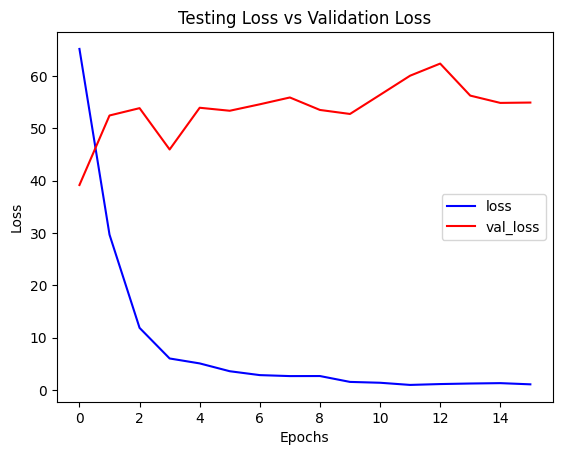

In [27]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Testing Loss vs Validation Loss', 'Loss')

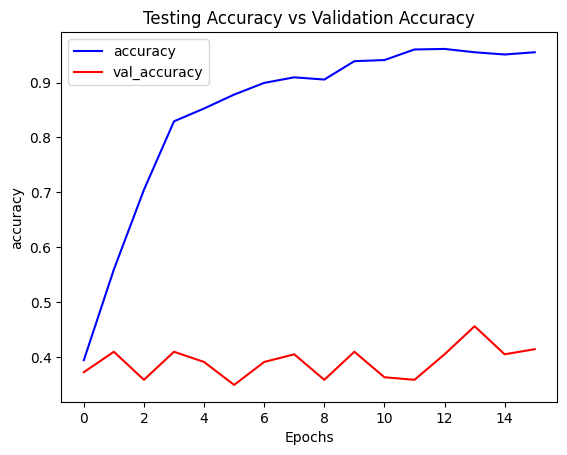

In [28]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Testing Accuracy vs Validation Accuracy') 

In [29]:
%%time

from keras.applications.vgg16 import preprocess_input

correct_preds = 0
total = len(nparray_labels["test"].keys())
for file_name in nparray_labels["test"].keys():
	frame = np.load(file_name)
	frame = frame/127.5
	frame -= 1.
	prediction = np.argmax(convlstm_model.predict(np.array([frame])))
	actual = nparray_labels["test"][file_name]
	if prediction == actual:
		correct_preds += 1
	# print(f'Prediction = {CLASSES_LIST[np.argmax(pred)]}')
	# print(f'Actual = {CLASSES_LIST[nparray_labels["test"]]}')

test_accuracy = correct_preds/total
print(f'Test Accuracy = {test_accuracy}')

1/1 [==============================] - 0s 106ms/step
Test Accuracy = 0.365296803652968
CPU times: user 44.5 s, sys: 15.7 s, total: 1min
Wall time: 45.8 s
